# 6) (TODO) Evaluate ABD Vs non-ABD and Cm-Ra Vs non-Cm-Ra

## cell1_211011_3436

This notebook uses the `runs.pkl` file created in notebook 2 and it computes and saves the responses and scores for all seeds and options.

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import sys
import shutil
from tqdm import tqdm

import bluepyopt as bpopt
import bluepyopt.ephys as ephys
import neuroplotlib as nplt

import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import distance
import MEAutility as mu
import json
import time
import numpy as np
from pathlib import Path
from pprint import pprint

import multimodalfitting as mf

%matplotlib notebook

--No graphics will be displayed.
/home/alessio/anaconda3/envs/multi/lib/python3.8/site-packages/igor-0.3-py3.8.egg/igor/util.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/alessio/anaconda3/envs/multi/lib/python3.8/site-packages/igor-0.3-py3.8.egg/igor/util.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [2]:
# general
base_dir = Path("../../..")

In [3]:
# general
cell_name = "cell1_211011_3436" # "cell1_211011_3436" | "cell1_211011_3436"
model_name = cell_name
ephys_dir = base_dir / "experimental_data" / cell_name / "patch_data"

cell_models_folder = base_dir / "cell_models"
model_folder = cell_models_folder / cell_name

In [4]:
result_dates = [r.name for r in (base_dir / "results").iterdir()]
# use latest results
results_date = max(result_dates)
result_folder = base_dir / "results" / results_date

In [5]:
# # select abd (axon_bearing_dendrite) option
# abd = True

In [6]:
save_fig = False
fig_folder = Path("../figures")

if save_fig:
    fig_folder.mkdir(exist_ok=True)

In [7]:
colors_dict = {"soma": "C0",
               "all": "C1",
               "sections": "C2",
               "single": "C3"}
feature_sets = {"soma": "soma",
                "all": "extra",
                "sections": "extra",
                "single": "extra"}
figsize = (10, 7)

# Define cell model and load optimization output

In [8]:
for abd in [False, True]:

    cell = mf.create_experimental_model(model_name=cell_name, abd=abd)
    cell_sample = mf.create_experimental_model(model_name=cell_name, release=True, abd=abd)

    probe = mf.define_electrode(probe_file=model_folder / "fitting" / "efeatures" / "probe_BPO.json")
    param_names = [param.name for param in cell.params.values() if not param.frozen]
    print(f"Number of parameters: {len(param_names)} (ABD={abd})")

Number of parameters: 42 (ABD=False)
Number of parameters: 51 (ABD=True)


In [9]:
pkl_file_name = "runs.pkl"

In [10]:
abd = False

In [19]:
data = pickle.load(open(result_folder / pkl_file_name, 'rb'))
df_optimization = pd.DataFrame(data)
df_model = df_optimization.query(f"model == '{model_name}' and abd == {abd}")

strategies = np.unique(df_model.strategy)

<IPython.core.display.Javascript object>


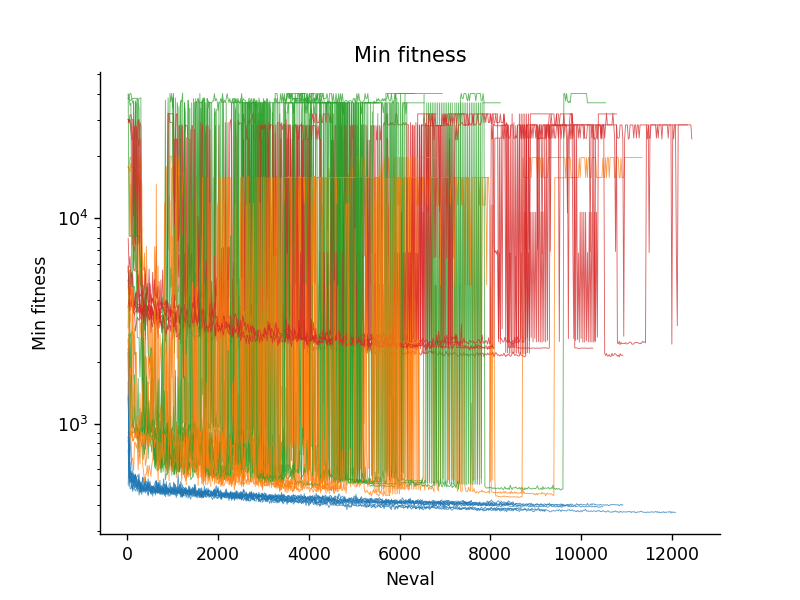

In [22]:
fig, ax = plt.subplots()
min_evals = 3000

keep_idxs = []
for idx, row in df_model.iterrows():
    color = mpl.colors.to_rgb(colors_dict[row["strategy"]])
    if row["cm_ra"]:
        keep_idxs.append(idx)
        ax.plot(row["nevals"], 
                row["logbook"].select("min"),
                color=color,
                ls='-', 
                lw=0.5,
                alpha=0.75)
    else:
        color = np.clip(np.array(color) - 0.3, 0, 1)
        ax.plot(row["nevals"], 
                row["logbook"].select("min"),
                color=color,
                ls='-', 
                lw=0.5,
                alpha=0.75)

ax.set_title("Min fitness")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Neval")
ax.set_ylabel("Min fitness")
ax.set_yscale('log')

In [23]:
len(df_model)

40

# Load protocols and experimental features

In [24]:
extra_kwargs = mf.utils.get_extra_kwargs()
extra_kwargs["ms_cut"] = [2, 5]

In [27]:
protocol_for_eap = "IDrest_300"
cm_ras = [False, True]

In [32]:
# check num features
for strategy in np.unique(df_model.strategy):
    extra_strategy = strategy if strategy in ["all", "single", "sections"] else None
    eva = mf.create_evaluator(
        model_name=model_name,
        strategy=strategy,
        protocols_with_lfp=protocol_for_eap,
        **extra_kwargs
    )
    print(f"Strategy {strategy} --> num features {len(eva.fitness_calculator.objectives)}")

Strategy all --> num features 87
Strategy sections --> num features 120
Strategy single --> num features 153
Strategy soma --> num features 76


In [33]:
eva_extra = mf.create_evaluator(
    model_name=model_name,
    strategy="all",
    protocols_with_lfp=protocol_for_eap,
    abd=abd,
    cm_ra=False,
    **extra_kwargs
)

## Load experimental responses

In [34]:
from bluepyefe.extract import read_recordings, extract_efeatures_at_targets, compute_rheobase,\
    group_efeatures, create_feature_protocol_files, convert_legacy_targets
from bluepyefe.plotting import plot_all_recordings_efeatures

from multimodalfitting.efeatures_extraction import build_wcp_metadata, wcp_reader, get_ecode_targets, \
    ecodes_wcp_timings

In [35]:
# define timings for this experiment
ecodes_cell_timings = {
    "IDthres": {
        'ton': 400,
        'toff': 670
    },
    "firepattern": {
        'ton': 500,
        'toff': 4100
    },
    "IV": {
        'ton': 400,
        'toff': 3400
    },
    "IDrest": {
        'ton': 400,
        'toff': 1750
    },
    "APWaveform": {
        'ton': 350,
        'toff': 400
    },
    "HyperDepol": {
        'ton': 400,
        'toff': 1120,
        'tmid': 850
    },
    "sAHP": {
        'ton': 400,
        'toff': 1325,
        'tmid': 650,
        'tmid2': 875
    },
    "PosCheops": {
        'ton': 1000,
        't1': 9000,
        't2': 10500,
        't3': 14500,
        't4': 16000,
        'toff': 18660
    }
}

In [36]:
if cell_name == "cell1_211011_3436":
    runs = [1, 2, 3, 4, 5]  # run1 --> different rheobase
elif cell_name == "cell1_211011_3436":
    runs = [3, 4, 5, 6]
    
ecode_names = list(ecodes_cell_timings.keys())

files_list = []

for run in runs:
    rep_dict = {}
    for ecode in ecode_names:
        for patch_file in ephys_dir.iterdir():
            if f"run{run}" in patch_file.name and ecode.lower() in patch_file.name:
                rep_dict[ecode] = patch_file
    files_list.append(rep_dict)

In [37]:
files_metadata = build_wcp_metadata(cell_id=cell_name, 
                                    files_list=files_list, 
                                    ecode_timings=ecodes_cell_timings, 
                                    repetition_as_different_cells=False)

In [38]:
cells = read_recordings(
    files_metadata=files_metadata,
    recording_reader=wcp_reader
)

In [39]:
# define target features for different protocols
targets = get_ecode_targets(ecodes_cell_timings)

In [40]:
global_tolerance = 30
for target in targets:
    target["tolerance"] = global_tolerance

In [41]:
if cell_name == "cell1_211011_3436":
    majority = 0.4
else:
    majority = 0.2

In [42]:
compute_rheobase(
    cells, 
    protocols_rheobase=['IDthres'],
    rheobase_strategy="majority",
    rheobase_settings={"majority": majority}
)

/home/alessio/anaconda3/envs/multi/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alessio/anaconda3/envs/multi/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
print(f"Cell rheobase: {cells[0].rheobase}")

Cell rheobase: 0.3255646184086801


In [44]:
protocols = group_efeatures(cells, targets, use_global_rheobase=True)

In [45]:
protocols_opt = list(eva_extra.fitness_protocols.keys())
print(protocols_opt)

['IDrest_150', 'IDrest_250', 'IDrest_300', 'IV_-100', 'IV_-20', 'APWaveform_290']


In [46]:
all_protocols = list(ecodes_cell_timings.keys())
print(all_protocols)

['IDthres', 'firepattern', 'IV', 'IDrest', 'APWaveform', 'HyperDepol', 'sAHP', 'PosCheops']


### Build BPO response dicts

In [47]:
responses_experimental = []
responses_all = []
num_runs = len(protocols[0].recordings)
for run in range(num_runs):
    print(f"Populating responses for run {run}")
    response_dict = {}
    response_all_dict = {}
    for protocol in protocols:
        for i, rec in enumerate(protocol.recordings):
            if i == run:
                response = bpopt.ephys.responses.TimeVoltageResponse(name=protocol.name,
                                                                     time=rec.t, voltage=rec.voltage)
                response_all_dict[f"{protocol.stimulus_name}.soma.v"] = response
                if protocol.stimulus_name in protocols_opt:
                    response_dict[f"{protocol.stimulus_name}.soma.v"] = response
    responses_experimental.append(response_dict)
    responses_all.append(response_all_dict)

Populating responses for run 0
Populating responses for run 1
Populating responses for run 2
Populating responses for run 3
Populating responses for run 4


In [48]:
responses_to_plot = ["APWaveform_290", "IDrest_250", "firepattern_200", "sAHP_250", "PosCheops_300"]
titles = responses_to_plot

<IPython.core.display.Javascript object>


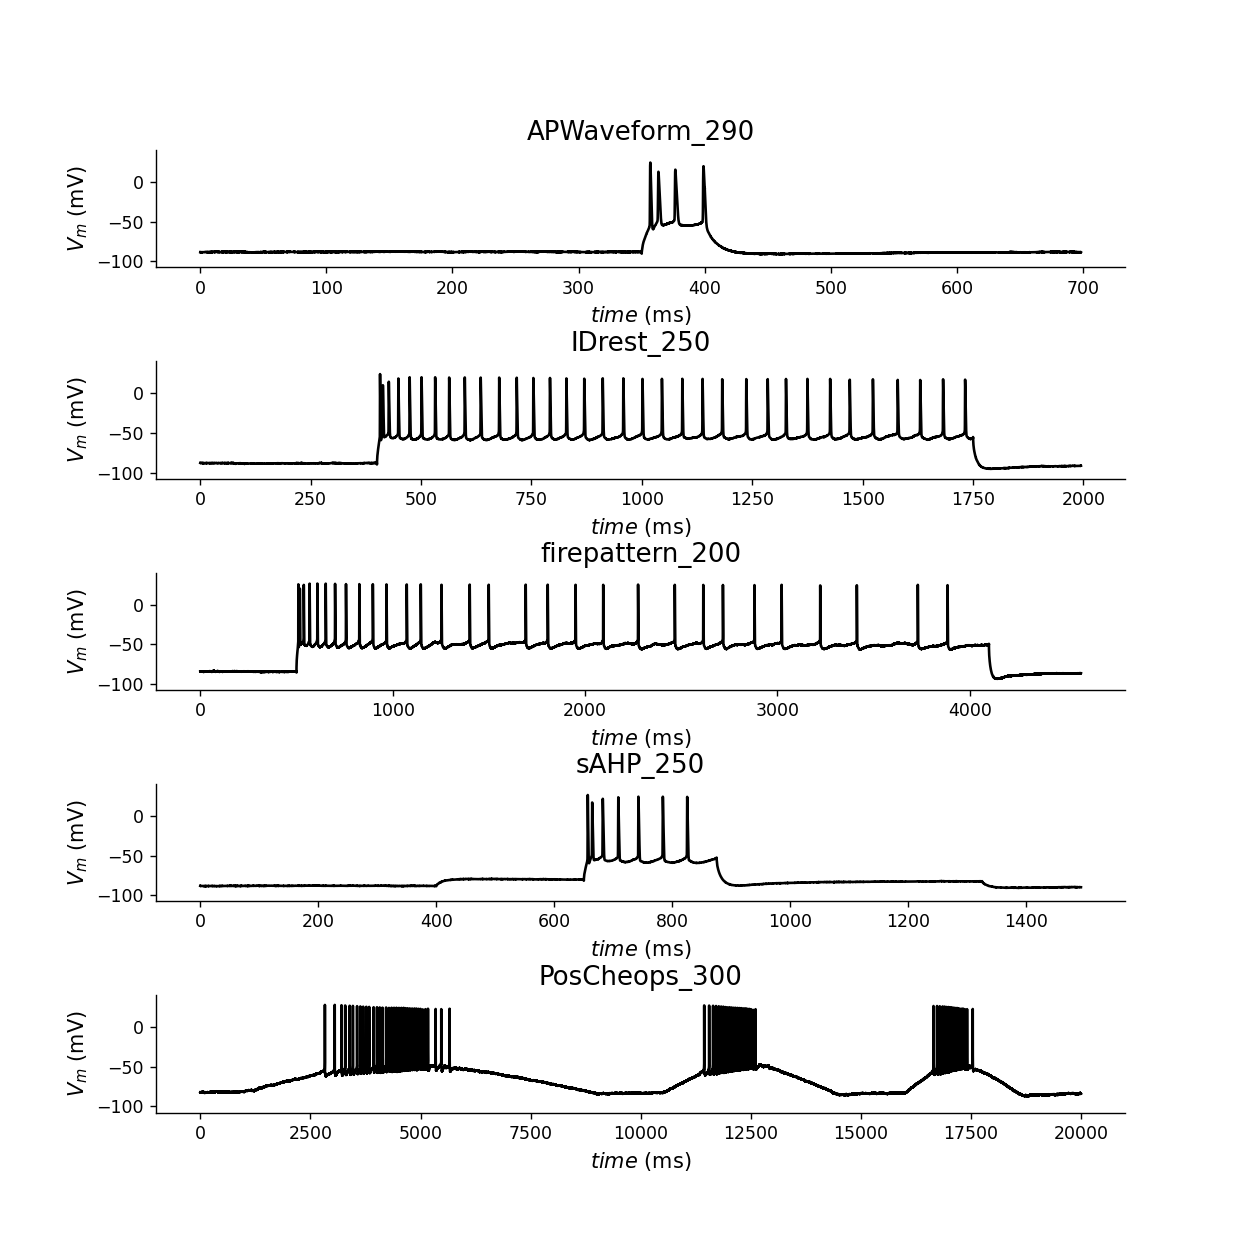

In [49]:
fig_exp_sample = mf.plot_responses(responses_all[2], return_fig=True, 
                                   titles=titles, protocol_names=responses_to_plot,
                                   color="k")

In [50]:
if save_fig:
    fig_exp_sample.savefig(fig_folder / f"{cell_name}_sample_response.pdf")
    fig_exp_sample.savefig(fig_folder / f"{cell_name}_sample_response.png", dpi=300)  

In [51]:
eap_exp = np.load(model_folder / "fitting" / "efeatures" / "template_BPO.npy") / 1000

<IPython.core.display.Javascript object>


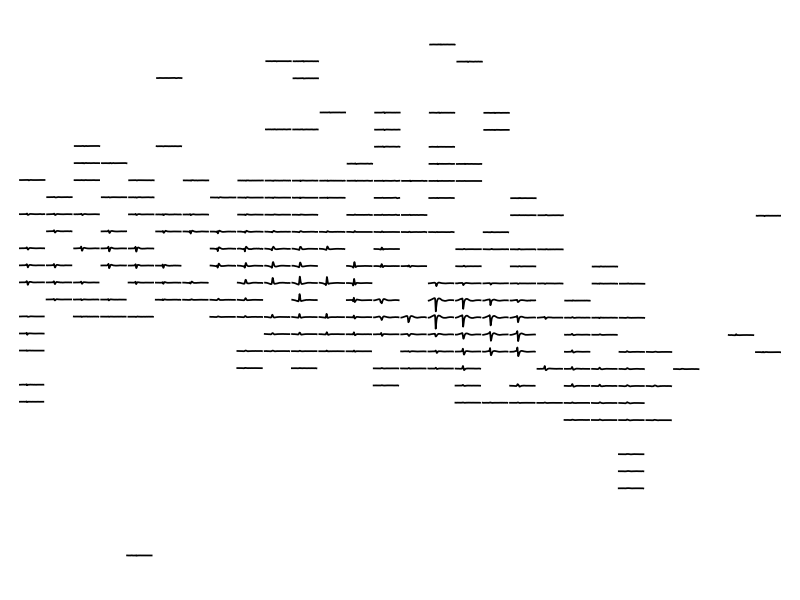

In [52]:
ax = mu.plot_mea_recording(eap_exp, probe)
fig_exp_extra = ax.get_figure()

In [54]:
vscale = np.max(np.abs(eap_exp))

In [55]:
if save_fig:
    fig_exp_intra.savefig(fig_folder / "exp_intra.png", dpi=300)
    fig_exp_extra.savefig(fig_folder / "exp_extra.png", dpi=300)

# Compute and plot best responses

In [ ]:
max_feature_value = 50

In [ ]:
#TODO keep track of ABD better

In [56]:
all_responses = []
all_eaps = []
all_params = []
all_abds = []
all_cm_ras = []
all_seeds = []
all_strategies = []

for strategy in strategies:
    print(f"Simulating '{strategy}'")
    # simulate all responses
    opt_df = df_model.query(f"strategy == '{strategy}'")

    for idx, row in opt_df.iterrows():
        abd = row.abd
        cm_ra = row.cm_ra

        eva_extra = mf.create_evaluator(
            model_name=model_name,
            strategy="all",
            protocols_with_lfp=protocol_for_eap,
            abd=abd,
            cm_ra=cm_ra,
            **extra_kwargs
        )

        param_names = [param.name for param in eva_extra.cell_model.params.values() if not param.frozen]

        param_boundaries = {}
        for param_name, param in eva_extra.cell_model.params.items():
            if not param.frozen:
                param_boundaries[param_name] = param.bounds

        seed = row.seed
        print(f"\tSeed {row.seed} -- ABD: {row.abd}")
        population = row.population
        scores = [sum(pop.fitness.values) for pop in population]
        best_individual_idx = np.argmin(scores)
        params = population[best_individual_idx]
        params_dict = {k: v for k, v in zip(param_names, params)}
        for param_name, param_value in params_dict.items():
            bounds = param_boundaries[param_name]
            if param_value < bounds[0] or param_value > bounds[1]:
                print(f"{param_name} out of bounds: {bounds}")

        responses_seed = eva_extra.run_protocols(eva_extra.fitness_protocols.values(), 
                                                 param_values=params_dict)
        eap_seed = mf.utils.calculate_eap(responses=responses_seed, protocols=eva_extra.fitness_protocols, 
                                          protocol_name=protocol_for_eap, align_extra=True, **extra_kwargs)
        all_strategies.append(strategy)
        all_params.append(params_dict)
        all_eaps.append(eap_seed)
        all_abds.append(abd)
        all_cm_ras.append(cm_ra)
        all_responses.append(responses_seed)
        all_seeds.append(seed)

opt_results_df = pd.DataFrame({"strategy": all_strategies, "params": all_params, "eap": all_eaps,
                               "abd": all_abds, "cm_ra": all_cm_ras, 
                               "responses": all_responses, "seed": all_seeds})

Simulating 'all'
	Seed 1 -- ABD: False


/home/alessio/Documents/codes/modeling/BluePyOpt/bluepyopt/ephys/responses.py:61: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response['voltage'] = pandas.Series(voltage)


	Seed 5 -- ABD: False


/home/alessio/Documents/codes/modeling/BluePyOpt/bluepyopt/ephys/responses.py:61: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response['voltage'] = pandas.Series(voltage)


	Seed 3 -- ABD: False


/home/alessio/Documents/codes/modeling/BluePyOpt/bluepyopt/ephys/responses.py:61: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response['voltage'] = pandas.Series(voltage)


	Seed 8 -- ABD: False


/home/alessio/Documents/codes/modeling/BluePyOpt/bluepyopt/ephys/responses.py:61: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response['voltage'] = pandas.Series(voltage)


	Seed 4 -- ABD: False


/home/alessio/Documents/codes/modeling/BluePyOpt/bluepyopt/ephys/responses.py:61: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response['voltage'] = pandas.Series(voltage)


	Seed 10 -- ABD: False



KeyboardInterrupt

/home/alessio/Documents/codes/modeling/BluePyOpt/bluepyopt/ephys/responses.py:61: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response['voltage'] = pandas.Series(voltage)


<IPython.core.display.Javascript object>


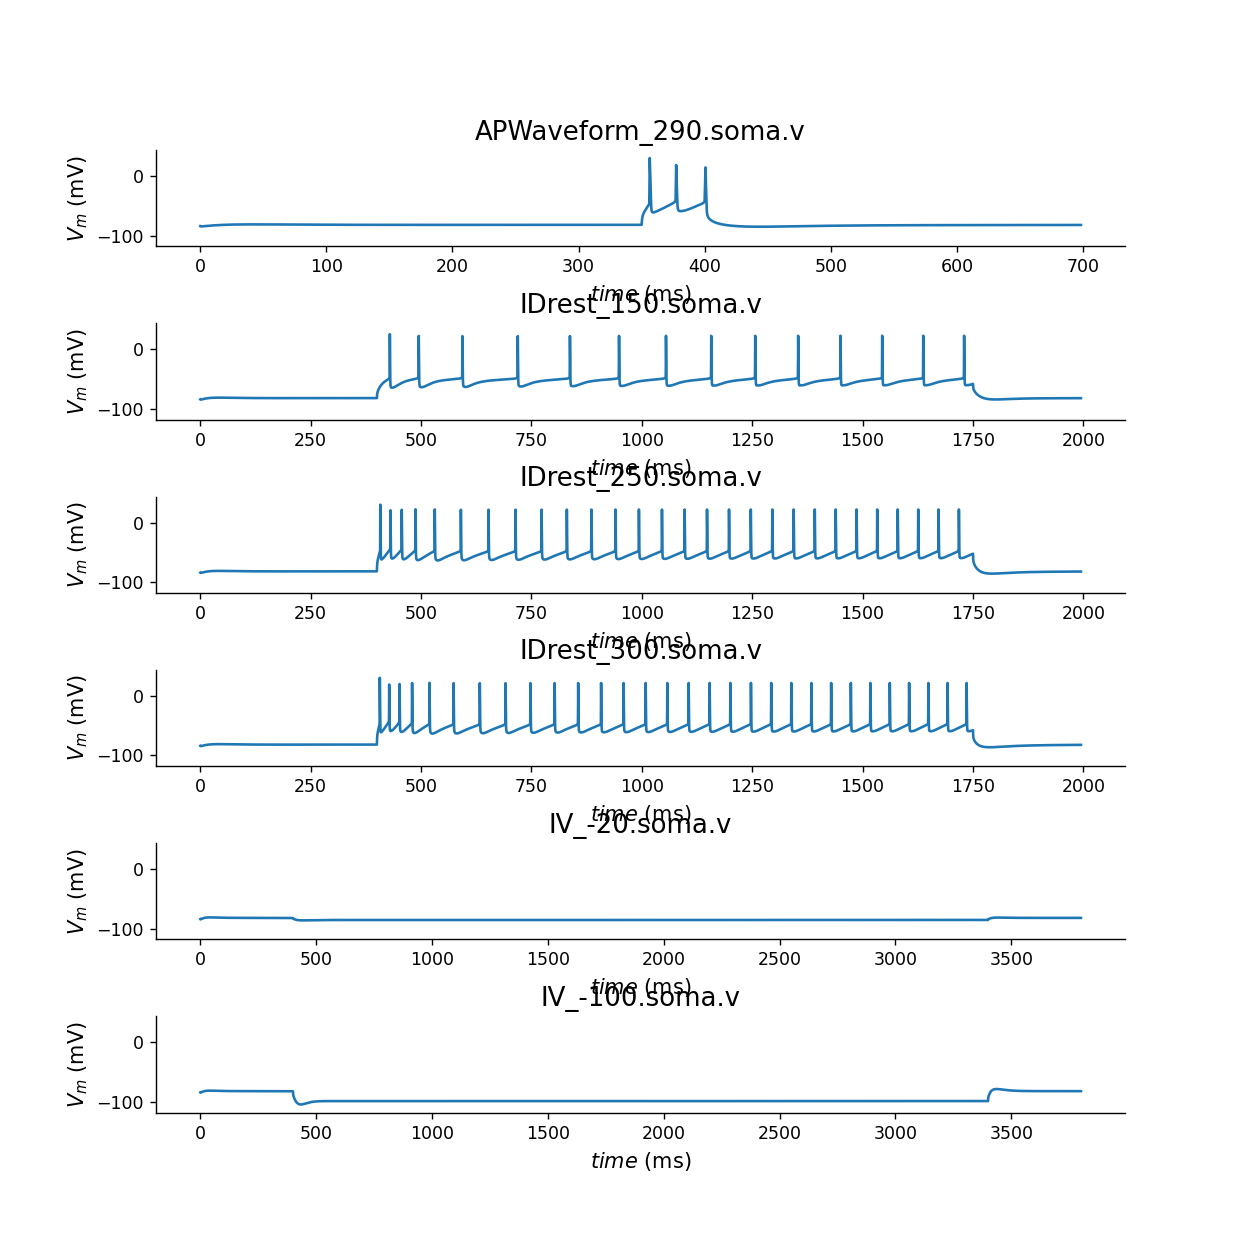

In [58]:
mf.plot_responses(all_responses[0])

In [ ]:
intra_scores = []
extra_scores = []
total_scores = []

for index, row in opt_results_df.iterrows():
    abd = row.abd
    responses  =row.responses
    seed = row.seed
    strategy = row.strategy

    eva_extra = mf.create_evaluator(
        model_name=model_name,
        strategy="all",
        protocols_with_lfp=protocol_for_eap,
        abd=abd,
        **extra_kwargs
    )

    param_names = [param.name for param in eva_extra.cell_model.params.values() if not param.frozen]

    extra_fitness = 0
    intra_fitness = 0
    for i in tqdm(np.arange(len(eva_extra.fitness_calculator.objectives)), 
                  desc=f"computing features {strategy}"):
        obj = eva_extra.fitness_calculator.objectives[i]
        feat = obj.features[0]
        if len(obj.features) == 1:
            feat_value = obj.features[0].calculate_feature(responses)
            feat_score = obj.features[0].calculate_score(responses)
            if "MEA" in feat.name:
                extra_fitness += feat_score
            else:
                intra_fitness += feat_score
    opt_results_df.at[index, "intra_score"] = intra_fitness
    opt_results_df.at[index, "extra_score"] = extra_fitness
    opt_results_df.at[index, "total_score"] = intra_fitness + extra_fitness

    print("strategy", strategy, "seed", seed, "abd", abd)
    print("\tINTRA", intra_fitness)
    print("\tEXTRA", extra_fitness)
    print("\tTOTAL", intra_fitness + extra_fitness)

### Save all responses and scores

In [ ]:
opt_results_df.to_pickle(result_folder / f"all_responses_{model_name}.pkl")

## ABD Vs NO ABD

In [ ]:
order = ["soma", "all", "sections", "single"]

In [ ]:
colors = [colors_dict[strat] for strat in order]
fig_intra_seeds, ax = plt.subplots(figsize=(7, 10))
sns.boxplot(data=opt_results_df, x="strategy", y="intra_score", hue="abd", order=order, 
            showfliers=False,  ax=ax) #palette=colors_dict,
ax.set_xlabel("Strategy", fontsize=15)
ax.set_ylabel("Score", fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_title("Intracellular\n(10 seeds)", fontsize=20)

fig_extra_seeds, ax = plt.subplots(figsize=(7, 10))
sns.boxplot(data=opt_results_df, x="strategy", y="extra_score", hue="abd",
            showfliers=True,  order=order) #palette=colors_dict,
ax.set_xlabel("Strategy", fontsize=15)
ax.set_ylabel("Score", fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_title("Extracellular\n(10 seeds)", fontsize=20)

In [ ]:
index_na = []
for index, row in opt_results_df.iterrows():
    eap = row.eap
    if np.any(np.isnan(eap)):
        index_na.append(index)
opt_results_df = opt_results_df.drop(index_na)
print(f"Dropped {len(index_na)} rows for no spikes")

In [ ]:
opt_results_df_no_abd = opt_results_df.query("abd == False")
# best responses are the solutions that minimize extra_score
best_total = opt_results_df_no_abd.loc[opt_results_df_no_abd.groupby("strategy")["total_score"].idxmin()]
best_extras = opt_results_df_no_abd.loc[opt_results_df_no_abd.groupby("strategy")["extra_score"].idxmin()]
best_intras = opt_results_df_no_abd.loc[opt_results_df_no_abd.groupby("strategy")["intra_score"].idxmin()]

In [ ]:
opt_results_best_no_abd = {}
for idx, row in best_extras.iterrows():
    strategy = row["strategy"]
    seed = row["seed"]
    abd = row.abd
    eap = row.eap
    
    opt_results_best_no_abd[strategy] = {}
    
    print("Strategy", strategy, "best seed", seed, "abd", abd)
    responses = row["responses"]
    opt_results_best_no_abd[strategy]["best_seed"] = row.seed
    opt_results_best_no_abd[strategy]["best_responses"] = row.responses
    opt_results_best_no_abd[strategy]["best_eap"] = row.eap
    opt_results_best_no_abd[strategy]["best_params"] = row.params
    eap_exp_norm = eap_exp / np.ptp(np.abs(eap_exp), 1, keepdims=True)
    eap_norm = eap / np.ptp(np.abs(eap), 1, keepdims=True)
    eap_dist = np.sum(np.abs(eap_exp_norm.ravel() - eap_norm.ravel()))
    opt_results_best_no_abd[strategy]["best_eap_dist"] = eap_dist
    print(eap_dist)

In [ ]:
opt_results_df_abd = opt_results_df.query("abd == True")
# best responses are the solutions that minimize extra_score
best_total = opt_results_df_abd.loc[opt_results_df_abd.groupby("strategy")["total_score"].idxmin()]
best_extras = opt_results_df_abd.loc[opt_results_df_abd.groupby("strategy")["extra_score"].idxmin()]
best_intras = opt_results_df_abd.loc[opt_results_df_abd.groupby("strategy")["intra_score"].idxmin()]

In [ ]:
opt_results_best_abd = {}

for idx, row in best_extras.iterrows():
    strategy = row["strategy"]
    seed = row["seed"]
    abd = row.abd
    eap = row.eap
    
    opt_results_best_abd[strategy] = {}
    
    print("Strategy", strategy, "best seed", seed, "abd", abd)
    responses = row["responses"]
    opt_results_best_abd[strategy]["best_seed"] = row.seed
    opt_results_best_abd[strategy]["best_responses"] = row.responses
    opt_results_best_abd[strategy]["best_eap"] = row.eap
    opt_results_best_abd[strategy]["best_params"] = row.params
    eap_exp_norm = eap_exp / np.ptp(np.abs(eap_exp), 1, keepdims=True)
    eap_norm = eap / np.ptp(np.abs(eap), 1, keepdims=True)
    eap_dist = np.sum(np.abs(eap_exp_norm.ravel() - eap_norm.ravel()))
    opt_results_best_abd[strategy]["best_eap_dist"] = eap_dist
    print(eap_dist)

In [ ]:
selected_strategies = ["soma", "all"]
responses_exp = responses_experimental[1]

In [ ]:
# plot
figs_intra = {}
figs_extra = {}
protocols_to_plot = ["APWaveform_290", "IDrest_250", "IV_-100"]
titles = protocols_to_plot
for strategy in selected_strategies:
    responses_to_plot = [responses_exp, opt_results_best_no_abd[strategy]["best_responses"]]
    colors = ["k", colors_dict[strategy]]
    labels = ["GT", strategy.upper()]
    fig_intra = mf.plot_multiple_responses(responses_to_plot, 
                                           protocol_names=protocols_to_plot,
                                           colors=colors, 
                                           titles=titles,
                                           return_fig=True, 
                                           labels=labels)
    
    
# plor extra
fig_extra, ax_extra = plt.subplots(figsize=figsize)
ax_extra = mu.plot_mea_recording(eap_exp, probe, vscale=vscale, lw=1, ax=ax_extra)
ax_extra.get_lines()[-1].set_label("GT")

for strategy in selected_strategies:
    eap = opt_results_best_no_abd[strategy]["best_eap"]
    ax_extra = mu.plot_mea_recording(eap, probe, ax=ax_extra, vscale=vscale, 
                                     colors=colors_dict[strategy], lw=1)
    ax_extra.get_lines()[-1].set_label(strategy.upper())
    ax_extra.set_title("EAP", fontsize=15)
ax_extra.legend()

In [ ]:
# plot
figs_intra = {}
figs_extra = {}
protocols_to_plot = ["APWaveform_290", "IDrest_250", "IV_-100"]
titles = protocols_to_plot
for strategy in selected_strategies:
    responses_to_plot = [responses_exp, opt_results_best_abd[strategy]["best_responses"]]
    colors = ["k", colors_dict[strategy]]
    labels = ["GT", strategy.upper()]
    fig_intra = mf.plot_multiple_responses(responses_to_plot, 
                                           protocol_names=protocols_to_plot,
                                           colors=colors, 
                                           titles=titles,
                                           return_fig=True, 
                                           labels=labels)
    
    
# plor extra
fig_extra, ax_extra = plt.subplots(figsize=figsize)
ax_extra = mu.plot_mea_recording(eap_exp, probe, vscale=vscale, lw=1, ax=ax_extra)
ax_extra.get_lines()[-1].set_label("GT")

for strategy in selected_strategies:
    eap = opt_results_best_abd[strategy]["best_eap"]
    ax_extra = mu.plot_mea_recording(eap, probe, ax=ax_extra, vscale=vscale, 
                                     colors=colors_dict[strategy], lw=1)
    ax_extra.get_lines()[-1].set_label(strategy.upper())
    ax_extra.set_title("EAP", fontsize=15)
ax_extra.legend()

### Best "ALL" ABD vs no ABD

In [ ]:
# plot
figs_intra = {}
figs_extra = {}
protocols_to_plot = ["APWaveform_290", "IDrest_250", "IV_-100"]
titles = protocols_to_plot

strategy = "all"

responses_to_plot = [responses_exp,
                     opt_results_best_no_abd[strategy]["best_responses"],
                     opt_results_best_abd[strategy]["best_responses"]]
colors = ["k", "C3", "C6"]
labels = ["GT", "No ABD", "ABD"]
fig_intra = mf.plot_multiple_responses(responses_to_plot, 
                                       protocol_names=protocols_to_plot,
                                       colors=colors, 
                                       titles=titles,
                                       return_fig=True, 
                                       labels=labels)

    
# plor extra
fig_extra, ax_extra = plt.subplots(figsize=figsize)
ax_extra = mu.plot_mea_recording(eap_exp, probe, vscale=vscale, lw=1, ax=ax_extra)
ax_extra.get_lines()[-1].set_label("GT")

eap_no_abd = opt_results_best_no_abd[strategy]["best_eap"]
ax_extra = mu.plot_mea_recording(eap_no_abd, probe, ax=ax_extra, vscale=vscale, 
                                 colors=colors[1], lw=2)
ax_extra.get_lines()[-1].set_label(labels[1])

eap_abd = opt_results_best_abd[strategy]["best_eap"]
ax_extra = mu.plot_mea_recording(eap_abd, probe, ax=ax_extra, vscale=vscale, 
                                 colors=colors[2], lw=2)
ax_extra.get_lines()[-1].set_label(labels[2])

ax_extra.set_title("EAP", fontsize=15)
ax_extra.legend()